# Распознавание рукописных цифр при помощи свёрточной нейронной сети

In [2]:
import torch
import random
import numpy as np

random.seed(0)
np.random.seed(0)
torch.manual_seed(0)
torch.cuda.manual_seed(0)
torch.backends.cudnn.deterministic = True

Загрузим набор данных MNIST:

In [3]:
import torchvision.datasets

In [4]:
MNIST_train = torchvision.datasets.MNIST('./', download=True, train=True)
MNIST_test = torchvision.datasets.MNIST('./', download=True, train=False)

Разделим данные на тестовые и тренировочные множества:

In [5]:
X_train = MNIST_train.train_data
y_train = MNIST_train.train_labels
X_test = MNIST_test.test_data
y_test = MNIST_test.test_labels

C:\Users\Ivan\AppData\Local\Programs\Python\Python311\Lib\site-packages\torchvision\datasets\mnist.py:75: UserWarning: train_data has been renamed data
  warnings.warn("train_data has been renamed data")
C:\Users\Ivan\AppData\Local\Programs\Python\Python311\Lib\site-packages\torchvision\datasets\mnist.py:65: UserWarning: train_labels has been renamed targets
  warnings.warn("train_labels has been renamed targets")
C:\Users\Ivan\AppData\Local\Programs\Python\Python311\Lib\site-packages\torchvision\datasets\mnist.py:80: UserWarning: test_data has been renamed data
  warnings.warn("test_data has been renamed data")
C:\Users\Ivan\AppData\Local\Programs\Python\Python311\Lib\site-packages\torchvision\datasets\mnist.py:70: UserWarning: test_labels has been renamed targets
  warnings.warn("test_labels has been renamed targets")


Посмотрим на количество элементов в `y_train` и `y_test`.

In [6]:
len(y_train), len(y_test)

(60000, 10000)

Выведем на экран одно из изображений:

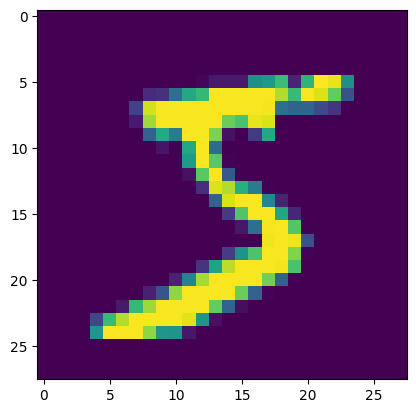

tensor(5)


In [7]:
import matplotlib.pyplot as plt
plt.imshow(X_train[0, :, :])
plt.show()
print(y_train[0])

Добавим ещё одну единичную размерность на место 1 и переведём данные в тип float:

In [8]:
X_train = X_train.unsqueeze(1).float()
X_test = X_test.unsqueeze(1).float()

Посмторим на получившиеся размерности `X_train` и `X_test`:

In [9]:
X_train.shape

torch.Size([60000, 1, 28, 28])

Создадим класс для нейронной сети: 
- первый свёрточный слой содержит 6 свёрток размера $5 times 5$ со сдвигом 2, с последующей функцией активации тангенс и average pooling размерностью $2 \times 2$;
- второй свёрточный слой содержит 16 свёрток размера $5 times 5$ без сдвига, с последующей функцией активации тангенс и average pooling размерностью $2 \times 2$;
- после них идёт полносвязный слой с функцией активации тангенс;
- в завершение расположен полносвязный выходной слой.

In [11]:
class LeNet5(torch.nn.Module):
    def __init__(self):
        super(LeNet5, self).__init__()
        
        self.conv1 = torch.nn.Conv2d(in_channels=1, out_channels=6, kernel_size=5, padding=2)
        self.act1  = torch.nn.Tanh()
        self.pool1 = torch.nn.AvgPool2d(kernel_size=2, stride=2)
       
        self.conv2 = torch.nn.Conv2d(in_channels=6, out_channels=16, kernel_size=5, padding=0)
        self.act2  = torch.nn.Tanh()
        self.pool2 = torch.nn.AvgPool2d(kernel_size=2, stride=2)
        
        self.fc1   = torch.nn.Linear(5 * 5 * 16, 120)
        self.act3  = torch.nn.Tanh()
        
        self.fc2   = torch.nn.Linear(120, 84)
        self.act4  =  torch.nn.Tanh()
        
        self.fc3   = torch.nn.Linear(84, 10)
    
    def forward(self, x):
        
        x = self.conv1(x)
        x = self.act1(x)
        x = self.pool1(x)
        
        x = self.conv2(x)
        x = self.act2(x)
        x = self.pool2(x)

        
        x = x.view(x.size(0), x.size(1) * x.size(2) * x.size(3))

        x = self.fc1(x)
        x = self.act3(x)
        x = self.fc2(x)
        x = self.act4(x)
        x = self.fc3(x)

        
        return x

Создадим экземпляр класса:

In [12]:
lenet5 = LeNet5()

Определим устрйоство, на котором будем обучать модель:

In [13]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
lenet5 = lenet5.to(device)


Определим функцию потерь через кросс-энтропию, а в качестве оптимизатора возьмём Adam с шагом обучения 0,001.

In [14]:
loss = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(lenet5.parameters(), lr=1.0e-3)

Обучим нашу нейронную сеть:

In [15]:
batch_size = 100

test_accuracy_history = []
test_loss_history = []

X_test = X_test.to(device)
y_test = y_test.to(device)


for epoch in range(10):
    order = np.random.permutation(len(X_train))
    for start_index in range(0, len(X_train), batch_size):
        optimizer.zero_grad()

        
        batch_indexes = order[start_index:start_index+batch_size]
        
        X_batch = X_train[batch_indexes].to(device)
        y_batch = y_train[batch_indexes].to(device)

        
        preds = lenet5.forward(X_batch)
        
        loss_value = loss(preds, y_batch)
        loss_value.backward()
      
        optimizer.step()

        
    test_preds = lenet5.forward(X_test)
    test_loss_history.append(loss(test_preds, y_test).data.cpu())
    
    accuracy = (test_preds.argmax(dim=1) == y_test).float().mean().data.cpu()
    test_accuracy_history.append(loss(test_preds, y_test).data.cpu())
    
    print(accuracy)

tensor(0.9751)
tensor(0.9836)
tensor(0.9855)
tensor(0.9876)
tensor(0.9884)
tensor(0.9889)
tensor(0.9862)
tensor(0.9880)
tensor(0.9893)
tensor(0.9881)


Выведем на экран значения точности и потерь:

In [16]:
lenet5.forward(X_test)


tensor([[-2.0440,  0.7168,  0.8082,  ..., 13.8697, -1.8578,  2.6725],
        [ 1.7804,  0.3758, 14.6097,  ..., -2.4750,  1.1967, -2.9959],
        [-0.3636, 14.0834, -0.3340,  ..., -0.1655,  1.6119, -1.9905],
        ...,
        [-3.7583, -1.3850, -2.9962,  ...,  0.8763,  0.6645,  3.1754],
        [-1.3811, -3.1725, -5.2641,  ..., -4.9247,  3.2191, -2.3926],
        [ 2.0821, -3.3662,  0.4541,  ..., -8.3261, -0.0820, -3.5690]],
       grad_fn=<AddmmBackward0>)

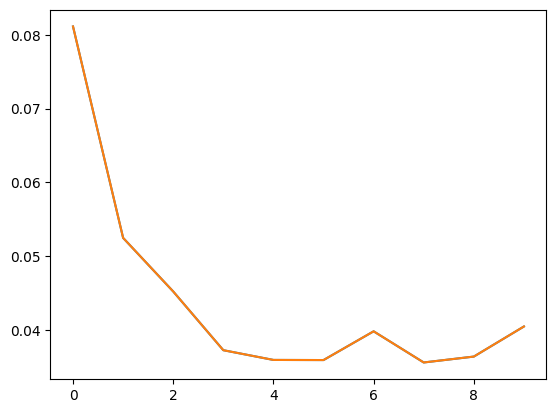

In [18]:
with torch.no_grad():
    plt.plot(test_accuracy_history);
    plt.plot(test_loss_history);